**Building a CNN with tensorflow for Malaria diagnosis**

In [14]:
import tensorflow as tf     #For Model
import numpy as np          #For Mathematical computation
import matplotlib.pyplot as plt             #For plotting charts and visualization
import tensorflow_datasets as tfds          #For loading the malaria dataset
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization      #To build our model and define hyperparameters
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

**Data Preparation**

In [2]:
dataset , dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])
#Loading our dataset from TF library
#loading it with it's info to get labels
#Shuffling our dataset to remove biases

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.BAP14T_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
def split(dataset , TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)                                           #We can use take() only on tf datasets

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))           #train_dataset takes first 80% of our dataset

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))        #val_test_dataset skips 80% of our data
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))      #val_dataset takes 10%

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))     #test_dataset skips what the val_dataset take so it take the last 10%

  return train_dataset, val_dataset, test_dataset

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)    #We used dataset[0] so we can pick only the actual dataset in the dataset
                                                                                                    #List and not pick the whole list which would cause an error

**Data Visualization**

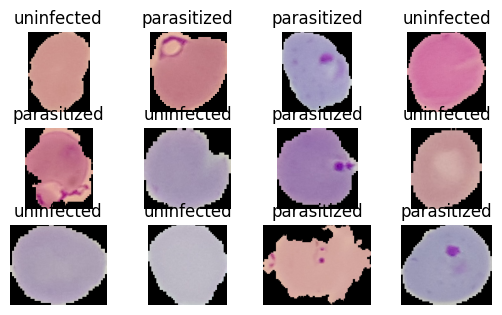

In [5]:
for i, (image, label) in enumerate(train_dataset.take(12)):       #Plotting images from our dataset
  ax = plt.subplot(4, 4, i+1)                                     #Size of the image
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))        #Showing each image label
  plt.axis("off")                                                 #Removing x and y axis from images

**Data Processing**

In [6]:
IMG_SIZE = 224                                                                      #Fixed size for all images
def resize_rescale(image, label):
  return tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0 , label               #Resizing all images to 224,224 and then rescaling it by deviding bt 255

In [7]:
train_dataset = train_dataset.map(resize_rescale)         #Calling the resize function to all resize the whole training dataset
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)    #Shuffling our training dataset

In [9]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Modeling**

In [10]:
model = tf.keras.Sequential([
              InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

              Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),     #Convolution layer for feature extraction
              BatchNormalization(),
              MaxPool2D(pool_size = 2, strides = 1),                                                         #Max Pool layer with size 2x2

              Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
              BatchNormalization(),
              MaxPool2D(pool_size = 2, strides = 1),

              Flatten(),                                            #Transform multidimensional tensors into 1D tensor

              Dense(100, activation = 'relu'),
              BatchNormalization(),
              Dense(50, activation = 'relu'),
              BatchNormalization(),
              Dense(10, activation = 'relu'),
              BatchNormalization(),
              Dense(1, activation = 'sigmoid'),           #Output is 1 where it's either parasitized or infected

])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 221, 221, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 219, 219, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 219, 219, 16)      64        
 chNormalization)                                                
                                                        

In [18]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),      #Our model error sanctioning function is BCE
              metrics = 'accuracy'             #Our performance measurment here is accuracy
)

In [19]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
hist = model.fit(train_dataset, validation_data = val_dataset, epochs = 50, verbose = 1 )        #Training our model

Epoch 1/50
689/689 [==============================] - 71s 90ms/step - loss: 0.6603 - accuracy: 0.6085 - val_loss: 0.6585 - val_accuracy: 0.5920
Epoch 2/50
689/689 [==============================] - 61s 88ms/step - loss: 0.2968 - accuracy: 0.8805 - val_loss: 0.2360 - val_accuracy: 0.9201
Epoch 3/50
689/689 [==============================] - 60s 87ms/step - loss: 0.2104 - accuracy: 0.9321 - val_loss: 0.2296 - val_accuracy: 0.9332
Epoch 4/50
689/689 [==============================] - 61s 89ms/step - loss: 0.1879 - accuracy: 0.9408 - val_loss: 0.2809 - val_accuracy: 0.9510
Epoch 5/50
689/689 [==============================] - 60s 87ms/step - loss: 0.1791 - accuracy: 0.9455 - val_loss: 0.4347 - val_accuracy: 0.6799
Epoch 6/50
689/689 [==============================] - 68s 98ms/step - loss: 0.1719 - accuracy: 0.9478 - val_loss: 0.9713 - val_accuracy: 0.4933
Epoch 7/50
689/689 [==============================] - 60s 87ms/step - loss: 0.1697 - accuracy: 0.9461 - val_loss: 1.8529 - val_accuracy:

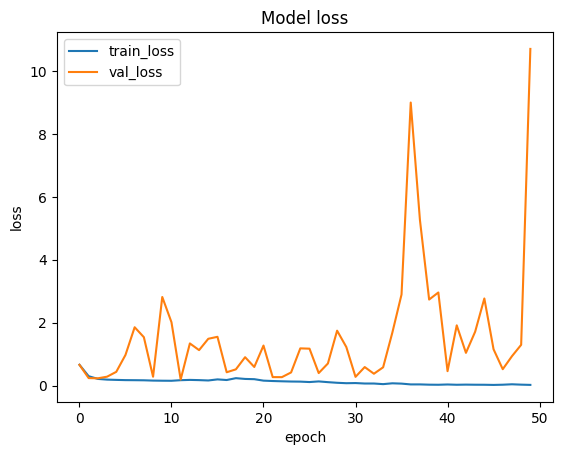

In [21]:
plt.plot(hist.history['loss'])                  #Plot our model loss
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

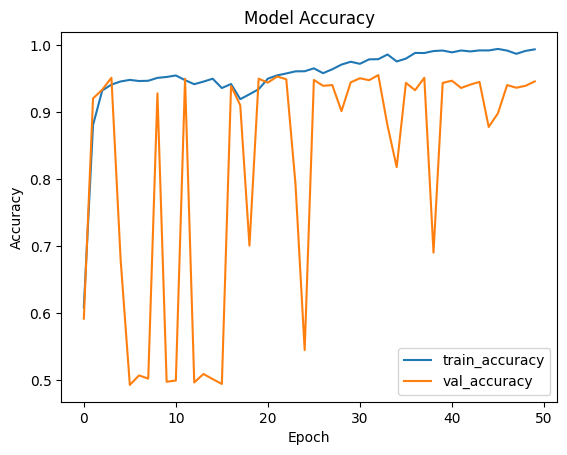

In [22]:
plt.plot(hist.history['accuracy'])        #Plot our model accuracy
plt. plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**Evaluating our model**

In [26]:
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [27]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])      #Predicting on new data from test dataset

1/1 [==============================] - 11s 11s/step


'U'

In [24]:
def parasite_or_not(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 27ms/step


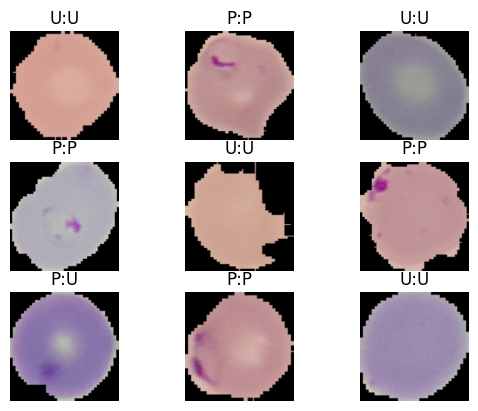

In [29]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot (3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')